Using cpu device


AssertionError: The algorithm only supports (<class 'gymnasium.spaces.discrete.Discrete'>,) as action spaces but Discrete(100) was provided

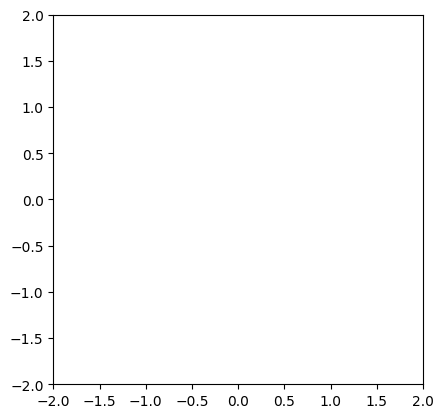

In [1]:
import gym
from gym import spaces
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback


class TwoLinkArmEnv(gym.Env):
    def __init__(self):
        super(TwoLinkArmEnv, self).__init__()
        self.link1_length = 1.0  # Length of the first link
        self.link2_length = 1.0  # Length of the second link
        self.max_angle = np.pi  # Maximum angle (in radians)
        
        # Action space: discrete action space of 10 levels per joint (discretized joint angles)
        self.num_actions = 10
        self.action_space = spaces.Discrete(self.num_actions * self.num_actions)

        # Observation space: two continuous values for joint angles (theta1, theta2)
        self.observation_space = spaces.Box(low=-self.max_angle, high=self.max_angle, shape=(2,), dtype=np.float32)

        # Initial state: joint angles (theta1, theta2)
        self.state = np.zeros(2, dtype=np.float32)

        # Initialize the plot for visualization
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(-2, 2)
        self.ax.set_ylim(-2, 2)
        self.ax.set_aspect('equal')

        # Discretize the joint angles
        self.angle_values = np.linspace(-self.max_angle, self.max_angle, self.num_actions)

    def step(self, action):
        # Convert the discrete action to the corresponding joint angles
        theta1_index = action // self.num_actions
        theta2_index = action % self.num_actions
        theta1 = self.angle_values[theta1_index]
        theta2 = self.angle_values[theta2_index]
        
        self.state = np.array([theta1, theta2], dtype=np.float32)

        # Calculate the end-effector position
        x1 = self.link1_length * np.cos(self.state[0])
        y1 = self.link1_length * np.sin(self.state[0])
        x2 = x1 + self.link2_length * np.cos(self.state[0] + self.state[1])
        y2 = y1 + self.link2_length * np.sin(self.state[0] + self.state[1])

        # Calculate the reward (negative distance to origin for simplicity)
        reward = -np.sqrt(x2**2 + y2**2)

        # Termination condition (no termination in this case)
        done = False
        
        return np.copy(self.state), reward, done, {}

    def reset(self):
        # Reset the state to the initial position
        self.state = np.zeros(2, dtype=np.float32)
        return np.copy(self.state)

    def render(self):
        # Calculate the joint positions for visualization
        x1 = self.link1_length * np.cos(self.state[0])
        y1 = self.link1_length * np.sin(self.state[0])
        x2 = x1 + self.link2_length * np.cos(self.state[0] + self.state[1])
        y2 = y1 + self.link2_length * np.sin(self.state[0] + self.state[1])

        # Plot the arm
        self.ax.clear()
        self.ax.set_xlim(-2, 2)
        self.ax.set_ylim(-2, 2)
        self.ax.set_aspect('equal')

        # Plot the first link
        self.ax.plot([0, x1], [0, y1], lw=4, color='blue')
        # Plot the second link
        self.ax.plot([x1, x2], [y1, y2], lw=4, color='green')

        # Plot the end effector (tip of the second link)
        self.ax.plot(x2, y2, 'ro')

        # Display the plot
        plt.draw()
        plt.pause(0.01)

    def close(self):
        # Close the environment
        plt.close(self.fig)

# Create and wrap the environment
env = DummyVecEnv([lambda: TwoLinkArmEnv()])

# Initialize DQN agent
model = DQN('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Save the trained model
model.save("dqn_two_link_arm")

# Evaluate the agent
obs = env.reset()
for _ in range(100):
    action, _state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()

env.close()
